In [1]:
# standart librairies
import os,sys
import numpy as np
import xarray as xr
import pandas as pd
import datetime

# plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import ticker

from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

In [3]:
# from dask.distributed import Client
import multiprocessing.popen_spawn_posix
from distributed import Client

c = Client()
# c = Client(n_workers=6, threads_per_worker=1, memory_limit="8 GiB",local_directory="/gpfsscratch/rech/cli/uor98hu/dask_tmp/")
c

Client Scheduler: tcp://127.0.0.1:35447 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 10 Memory: 20.97 GB


# loading Altimetry observations products in the Arctic

In [4]:
dec_year = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/dec_year_1m_2005-2018.nc").dec_year

In [5]:
# monthly time series 
slats_DTU      = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/cci_dtu_tum_arctic_sla_ts_BGRbox.nc").ts_sla_box
slats_CPOM     = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/Full_DOT_data_Arco_ts_BGRbox.nc").ts_sla_box
slats_Armitage = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/CPOM_DOT_ts_BGRbox.nc").ts_sla_box
slats_SAGA     = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Doglioni/SAGA_sla_ts_BGRbox.nc").ts_sla_box
slats_PRANDI_adt= xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/PRANDI/Prandi_adt_ts_BGRbox.nc").ts_sla_box
slats_PRANDI   = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/PRANDI/Prandi_sla_ts_BGRbox.nc").ts_sla_box
slats_ECCO     = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/ECCO/BGRmask_ssh_ecco_ts.nc").ssh_ecco_ts
slats_ECCO2plot = slats_ECCO - slats_ECCO.mean('time_counter')


In [6]:
# yearly time series
slats_DTU_1y = slats_DTU.sel(time_counter=slice("1993","2017")).groupby('time_counter.year').mean('time_counter') #1993 to 2017
slats_CPOM_1y = slats_CPOM.groupby('time_counter.year').mean('time_counter') #2011 to 2018;  
slats_Armitage_1y = slats_Armitage.groupby('time_counter.year').mean('time_counter') #2003 to 2014;  
slats_SAGA_1y = slats_SAGA.groupby('time_counter.year').mean('time_counter') #2011 to 2018;
slats_PRANDI_1y = slats_PRANDI.groupby('time_counter.year').mean('time_counter') #2011 to 2018;
slats_ECCO2plot_1y = slats_ECCO2plot.groupby('time_counter.year').mean('time_counter') #1992 to 2017;  


In [7]:
GMSL_AVISO = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/AVISO_DATA/MSL_Serie_MERGED_Global_AVISO_GIA_NoAdjust_Filter2m.nc").msl.sel(time=slice("1993","2018")).rename({'time':'time_counter'})
GMSL_AVISO_1m = GMSL_AVISO.resample(time_counter="1M").mean()
GMSL_AVISO_1y = GMSL_AVISO.resample(time_counter="1Y").mean().rename({"time_counter":"year"}).assign_coords(year=("year",np.arange(1993,2019)))

GMSL_ECCO_NASA  = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/ECCO/GLOBAL_MEAN_SEA_LEVEL_mon_mean_ECCO_V4r4_1D.nc").global_mean_sea_level_anomaly
GMSL_ECCO_NASA_1y = GMSL_ECCO_NASA.groupby('time.year').mean('time')


### correct the yearly time series from the GMSL

In [8]:
slats_DTU_1y_corr = slats_DTU_1y           - GMSL_AVISO_1y
slats_CPOM_1y_corr = slats_CPOM_1y         - GMSL_AVISO_1y
slats_Armitage_1y_corr = slats_Armitage_1y - GMSL_AVISO_1y
slats_SAGA_1y_corr = slats_SAGA_1y         - GMSL_AVISO_1y
slats_PRANDI_1y_corr = slats_PRANDI_1y     - GMSL_AVISO_1y
slats_ECCO2plot_1y_corr= slats_ECCO2plot_1y - GMSL_ECCO_NASA_1y

# Load model data

In [12]:
ssh_1y = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/GAI_ts1980-2018_ssh_BGRbox.nc').ssh_BGRbox

In [13]:
# adjust the reference of the SLA of the altimetry products 
slats_DTU_1y_corr_match2       = slats_DTU_1y_corr       - slats_DTU_1y_corr.mean() + ssh_1y.sel(year=slice('1993','2017')).mean()
slats_CPOM_1y_corr_match2      = slats_CPOM_1y_corr      - slats_CPOM_1y_corr.mean() + ssh_1y.sel(year=slice('2011','2018')).mean()
slats_Armitage_1y_corr_match2  = slats_Armitage_1y_corr  - slats_Armitage_1y_corr.mean() + ssh_1y.sel(year=slice('2003','2014')).mean()
slats_SAGA_1y_corr_match2      = slats_SAGA_1y_corr      - slats_SAGA_1y_corr.mean() + ssh_1y.sel(year=slice('2011','2018')).mean()
slats_PRANDI_1y_corr_match2    = slats_PRANDI_1y_corr    - slats_PRANDI_1y_corr.mean() + ssh_1y.sel(year=slice('2011','2018')).mean()
slats_ECCO2plot_1y_corr_match2 = slats_ECCO2plot_1y_corr - slats_ECCO2plot_1y_corr.mean() + ssh_1y.sel(year=slice('1992','2017')).mean()

# compute data for paper text

In [15]:
## ---- compute std over their respective time periods (to get the interannual variability)
print((ssh_1y*100).std().values)
print((slats_ECCO2plot_1y_corr_match2*100).std().values)
print((slats_DTU_1y_corr_match2*100).std().values)
print((slats_CPOM_1y_corr_match2*100).std().values)
print((slats_Armitage_1y_corr_match2*100).std().values)
print((slats_SAGA_1y_corr_match2*100).std().values)
print((slats_PRANDI_1y_corr_match2*100).std().values)

6.805756276711121
6.350007500578269
3.4324714589493603
1.9353674016746505
4.71479729372861
1.0558502849848816
1.1172744552228104


In [23]:
# compute pearson's correlation coefficient (measure of correspondance between datasets)
print(str(np.round(xr.corr(ssh_1y.sel(year=slice(1992,2017)), slats_ECCO2plot_1y_corr_match2).values,2)))
print(str(np.round(xr.corr(ssh_1y, slats_DTU_1y_corr_match2).values,2)))
print(str(np.round(xr.corr(ssh_1y, slats_CPOM_1y_corr_match2).values,2)))
print(str(np.round(xr.corr(ssh_1y, slats_Armitage_1y_corr_match2).values,2)))
print(str(np.round(xr.corr(ssh_1y, slats_SAGA_1y_corr_match2).values,2)))
print(str(np.round(xr.corr(ssh_1y, slats_PRANDI_1y_corr_match2).values,2)))

0.93
0.25
0.64
0.82
0.36
0.49


In [50]:
# test of significance
r_ecco = 0.93
r_dtu = 0.25
r_cpom = 0.64
r_armi = 0.82
r_saga = 0.36
r_prandi = 0.49

#compute the t value: n is the lenght of the time series (number of years)
def compute_t(r, n):
    return r /np.sqrt((1-r**2)/(n-2))

t_ecco = compute_t(r_ecco,26)
t_dtu = compute_t(r_dtu,25)
t_cpom = compute_t(r_cpom,8)
t_armi = compute_t(r_armi,12)
t_saga = compute_t(r_saga,8)
t_prandi = compute_t(r_prandi,8)

print(t_ecco)
print(t_dtu)
print(t_cpom)
print(t_armi)
print(t_saga)
print(t_prandi)

12.3954099572738
1.2382783747337807
2.0402454818026827
4.530455884900604
0.9451890567189065
1.3768717296714377


In [52]:
from scipy import stats
# compute t* : (stats.t.ppf(1-alpha,dof-2))

print(stats.t.ppf(1-0.05,24))
print(stats.t.ppf(1-0.05,23))
print(stats.t.ppf(1-0.05,6))
print(stats.t.ppf(1-0.05,10))
print(stats.t.ppf(1-0.05,6))
print(stats.t.ppf(1-0.05,6))

# is significant if t is > t*

1.7108820799094275
1.7138715277470473
1.9431802803927816
1.8124611228107335
1.9431802803927816
1.9431802803927816


In [14]:
# compute trend for exp1 and Ecco and their significance
import esmtools

t1 = "2005"
t2 = "2017"

ssh_1y_cm = (ssh_1y.sel(year=slice(t1,t2))*100).compute()
lin_ssh_1y = esmtools.stats.linregress(ssh_1y_cm, dim="year")

ecco_cm = (slats_ECCO2plot_1y_corr_match2.sel(year=slice(t1,t2))*100).compute()
lin_ecco = esmtools.stats.linregress(ecco_cm, dim="year")


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


<xarray.DataArray ()>
array(6.46378952e-06)
Coordinates:
    time_counter  float64 0.0
    deptht        float32 0.5058
    parameter     <U9 'pvalue'

In [90]:
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, 13-2) # = 2.1788 # is the number of years for the ssh and ecco trends

print(f"exp1 slope (95%): {lin_ssh_1y.sel(parameter='slope').values:.2f}  +/- {ts*lin_ssh_1y.sel(parameter='stderr').values:.2f}")
print(f"ecco slope (95%): {lin_ecco.sel(parameter='slope').values:.2f}  +/- {ts*lin_ecco.sel(parameter='stderr').values:.2f}")

exp1 slope (95%): 1.39  +/- 0.32
ecco slope (95%): 1.27  +/- 0.35


In [92]:
# compute trend for Armitage and the significance
armi_cm = (slats_Armitage_1y_corr_match2.sel(year=slice("2003","2014"))*100).compute()
lin_armi = esmtools.stats.linregress(armi_cm, dim="year")

print(lin_armi.sel(parameter='slope').values)
print(lin_armi.sel(parameter='pvalue').values< 0.05 ) # if True i significant

ts = tinv(0.05, 12-2)

print(f"exp1 slope (95%): {lin_armi.sel(parameter='slope').values:.2f}  +/- {ts*lin_armi.sel(parameter='stderr').values:.2f}")

0.9329350359196478
True
exp1 slope (95%): 0.93  +/- 0.70


In [82]:
# compute trend for DTU/TUM and the significance
cm = (slats_DTU_1y_corr_match2*100).compute()
lin_ = esmtools.stats.linregress(cm, dim="year")

print(lin_.sel(parameter='slope').values)
print(lin_.sel(parameter='pvalue').values< 0.05 ) # if True i significant

0.05614060355195571
False


In [87]:
# compute trend for PRANDI and the significance
cm = (slats_PRANDI_1y_corr_match2*100).compute()
lin_ = esmtools.stats.linregress(cm, dim="year")

print(lin_.sel(parameter='slope').values)
print(lin_.sel(parameter='pvalue').values< 0.05 ) # if True i significant

0.16441469129359365
False


# Plot figure

ts_1y_allobs_model_AvisoGMSLcorrectionshiftedfinal.png


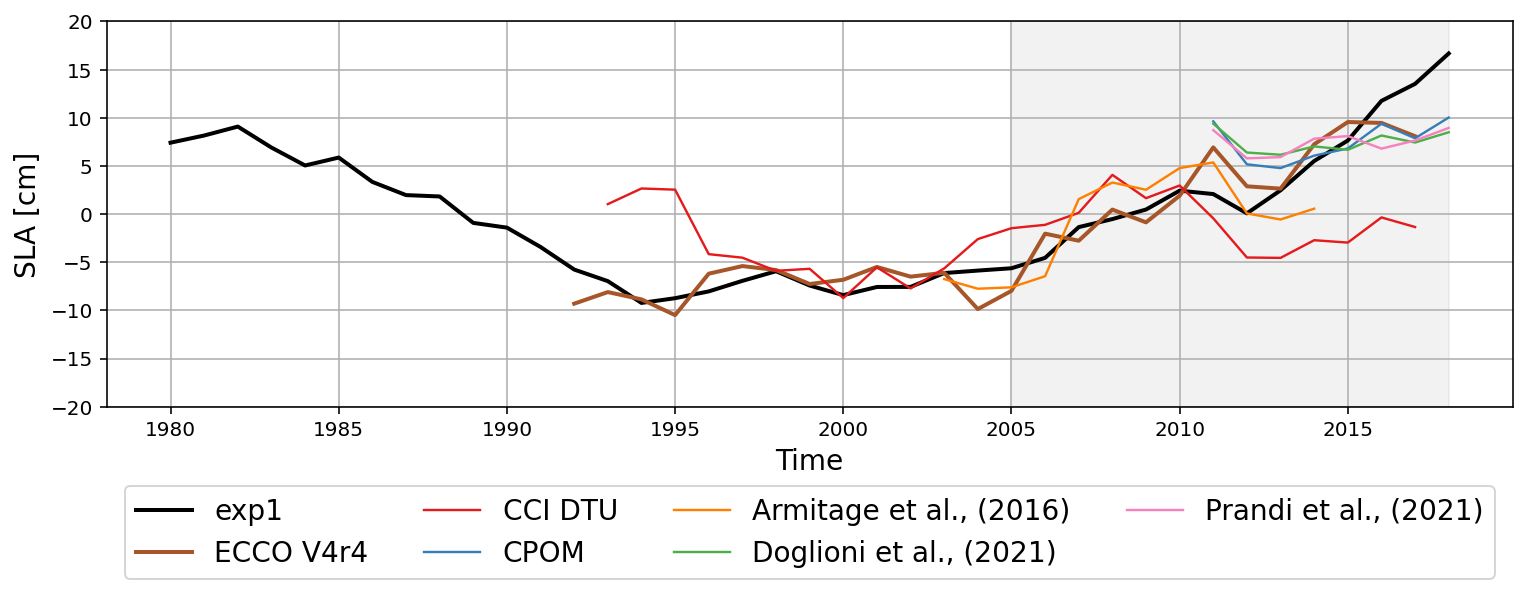

In [16]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_1y_allobs_model_AvisoGMSLcorrectionshiftedfinal.png'
print(namo)
centim = 1/2.54  # centimeters in inches

fig ,(ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(32*centim, 9*centim), facecolor='none', dpi=72*2)

(ssh_1y*100).plot(ax=ax1, color='k', linewidth=2)
(slats_ECCO2plot_1y_corr_match2*100).plot(ax=ax1, color=CB_colors['brown'], linewidth=2)
(slats_DTU_1y_corr_match2*100).plot(ax=ax1, color=CB_colors['red'], linewidth=1.2)
(slats_CPOM_1y_corr_match2*100).plot(ax=ax1, color=CB_colors['blue'], linewidth=1.2)
(slats_Armitage_1y_corr_match2*100).plot(ax=ax1, color=CB_colors['orange'], linewidth=1.2)
(slats_SAGA_1y_corr_match2*100).plot(ax=ax1, color=CB_colors['green'], linewidth=1.2)
(slats_PRANDI_1y_corr_match2*100).plot(ax=ax1, color=CB_colors['pink'], linewidth=1.2)

ax1.grid()
ax1.legend(['exp1',"ECCO V4r4",'CCI DTU', 'CPOM', 'Armitage et al., (2016)',"Doglioni et al., (2021)","Prandi et al., (2021)"], 
           loc='upper center',ncol=4, bbox_to_anchor=(0.5, -0.17), fancybox=True, fontsize = 14)
ax1.set_title('')
ax1.set_xlabel('Time',fontsize = 14); 
ax1.set_ylabel('SLA [cm]',fontsize = 14)

lim1 = -20
lim2 = 20
ax1.set_ylim(lim1,lim2)

ax1.axvspan(2005, 2018, color="grey", alpha=0.1)

plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0.1, bbox_inches='tight') #,edgecolor='none', bbox_inches='tight'
plt.close(fig)